# Glasgow analysis review

This notebook will contain examples of running the `lalapps_pulsar_parameter_estimation_nested` code and some post-processing. This will focus on recovering software and hardware injections.

Code tests:

 * [sample from prior](#Sample-from-prior)
 * [simulated Gaussian noise (single harmonic, old code comparison)](#Simulated-Gaussian-noise---single-harmonic,-old-code-comparison)
 * [simulated Gaussian noise (single harmonic)](#Simulated-Gaussian-noise--single-harmonic)
 * [simulated Gaussian noise (two harmonics)](#Simulated-Gaussian-noise---two-harmonics)
 * [simulated signal (single harmonic)](#Simulated-signal---single-harmonic)
 * [simulated signal (two harmonics)](#Simulated-signal---two-harmonics)
 * [hardware injection (single harmonic)](#Hardware-injection---single-harmonic)
 * [simulated signal (single harmonic and ROQ)](#Simulated-signal---single-harmonic-and-ROQ)
 * [simulated Gaussian noise (single harmonic and glitch)](#Simulated-Gaussian-noise---single-harmonic-and-glitch)
 * [simulated signal (two harmonics and glitch)](#Simulated-signal---dual-harmonic-and-glitch)

In [26]:
%matplotlib inline

import os
import re
import numpy as np
import subprocess as sp
from scipy import stats

from lalapps.pulsarpputils import pulsar_nest_to_posterior, upper_limit_greedy, psr_par
from lalpulsar.PulsarParametersWrapper import PulsarParametersPy
from scotchcorner import scotchcorner

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set executables
execpath = '/home/matthew/.conda/envs/master/bin'

lppen = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
lppe = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')
n2p = os.path.join(execpath, 'lalinference_nest2pos')

## Sample from prior

In the below test we will just draw samples from the specified prior to check that the points are distributed as expected. We will draw points from the following priors:

 * Uniform
 * unimodal Gaussian
 * multivariate Gaussian
 * Fermi-Dirac
 * Gaussian Mixture Model for one parameter with two modes

In [3]:
detectors = 'H1'
harmonics = '1,2'

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526           1 1e-7
F1        -2.075e-12            1 2e-15
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()


# C21 Gaussian Mixture Model prior parameters
c21modes = 2
c21means = [[5e-23], [1e-22]]
c21vars = [[[3e-47]], [[6e-47]]]
c21weights = [2, 1]

# C22 Fermi-Dirac prior parameters
fdsigma = 1e-23
fdr = 9.1625
fdmu = fdsigma*fdr

# PHI22 Uniform prior parameters
phi22min = 0.0
phi22max = 2.*np.pi

# PHI21 unimodal Gaussian prior parameters
phi21mu = 2.9
phi21sigma = 0.7

# F0:F1 multivariate Gaussian prior parameters
f0mu = 132.7885526
f0sigma = 1e-7
f1mu = -2.075e-12
f1sigma = 2e-15
corcoeff = 0.5  # correlation coefficient

# set the prior
priorcontent = """
C22      fermidirac {} {}
C21      gmm        {} {} {} {}
PHI22    uniform    {} {}
PHI21    gaussian   {} {}
F0       gaussian   {} {}
F1       gaussian   {} {}
"""

# correlation coefficient file (for F0 and F1)
corcontent = """       F0 F1
F0     1
F1     {} 1
"""

corfile = 'cor.txt'
fp = open(corfile, 'w')
fp.write(corcontent.format(corcoeff))
fp.close()

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent.format(fdsigma, fdr,
                             c21modes,
                             re.sub('\s+', '', str(c21means)),
                             re.sub('\s+', '', str(c21vars)),
                             re.sub('\s+', '', str(c21weights)),
                             phi22min, phi22max,
                             phi21mu, phi21sigma,
                             f0mu, f0sigma,
                             f1mu, f1sigma))
fp.close()

# nested sampling arguments
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)
priorsamples = 40000  # number of samples from the prior

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--par-file', parfile,
                   '--cor-file', corfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(priorsamples),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--outfile', outfile,
                   '--sampleprior', '{}'.format(priorsamples)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get prior samples
from lalinference.io import read_samples
from lalinference import LALInferenceHDF5NestedSamplesDatasetName
from lalinference import bayespputils as bppu
from lalinference.bayespputils import replace_column

samples = read_samples(outfile, tablename=LALInferenceHDF5NestedSamplesDatasetName)
params = samples.colnames

# make everything a float, since that's what's excected of a CommonResultsObj
for param in params:
    replace_column(samples, param, samples[param].astype(float))

nsResultsObject = (samples.colnames, samples.as_array().view(float).reshape(-1, len(params)))

post = bppu.Posterior( nsResultsObject, SimInspiralTableEntry=None )

/home/matthew/.conda/envs/master/lib/python3.6/site-packages/ipykernel_launcher.py:108: MovedWarning: "lalinference.io" has moved to ligo.skymap.

The lalinference.io module from LALInference has been replaced by the
ligo.skymap.io module from the ligo.skymap package. The old module is
no longer tested and supported and will be removed in a future version
of LALInference. Please update to the ligo.skymap package.

You can install ligo.skymap with pip by running this command in your
shell:

    pip install ligo.skymap



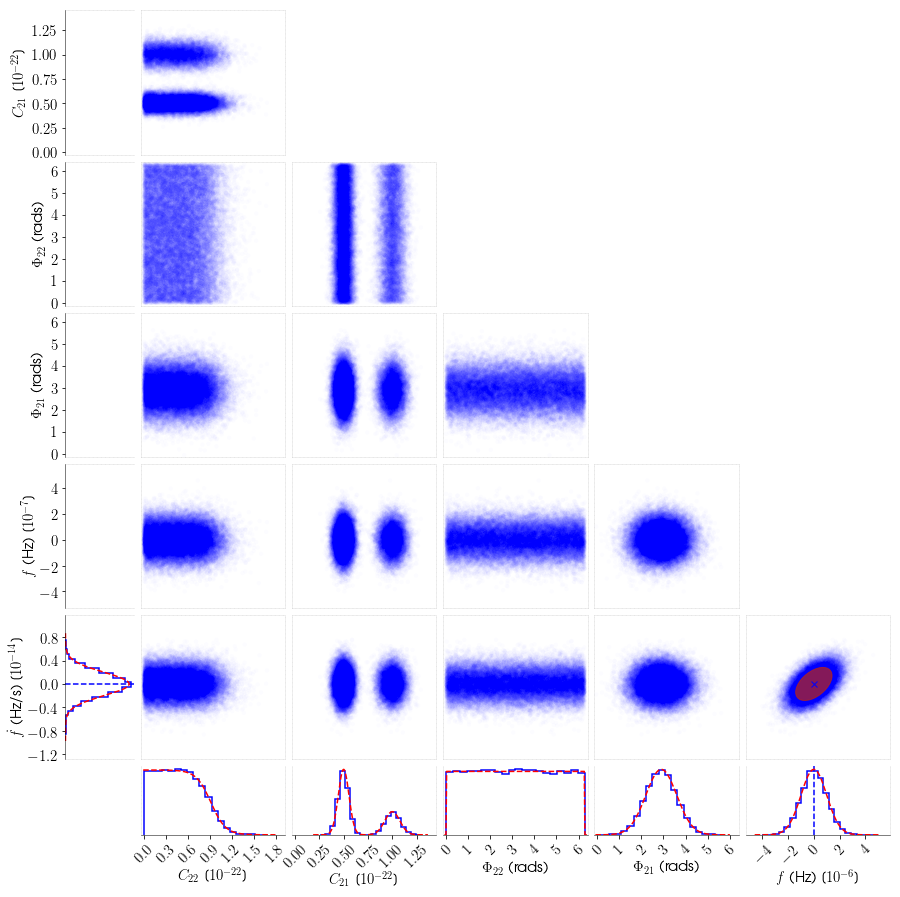

In [4]:
def gmmpdf(x, modes):
    """
    Create a Gaussian Mixture Model pdf.
    """
    
    gp = np.zeros(len(x))
    for i in range(len(modes['means'])):
        mu = modes['means'][i]
        sigma = modes['sigmas'][i]
        weight = modes['weights'][i]
        rv = stats.norm(loc=mu, scale=sigma) # create mode
        gp += weight*rv.pdf(x) # weight each mode

    # re-normalise
    return gp/np.trapz(gp, x)


def fermidiracpdf(x, sigma, mu):
    """
    Create a Fermi-Dirac pdf.
    """
    
    return 1./(sigma*np.log(1.+np.exp(mu/sigma))*(1.+np.exp((x-mu)/sigma)))


# get required parameter columns
params = ['C22', 'C21', 'PHI22', 'PHI21', 'F0', 'F1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['c22'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$C_{22}$', r'$C_{21}$', r'$\Phi_{22}$ (rads)', r'$\Phi_{21}$ (rads)',
          r'$f$ (Hz)', r'$\dot{f}$ (Hz/s)']
limits = [(0., None), (0, None), (0., 2.*np.pi),
          (0., 2.*np.pi), (None, None), (None, None)]

truths = [None, None, None, None, f0mu, f1mu]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  truths=truths, subtract_truths=[4, 5],
                  showpoints=True, scatter_kwargs={'alpha': 0.01})

# overplot the GMM prior
modes = {}
modes['means'] = [mu[0] for mu in c21means]
modes['sigmas'] = [np.sqrt(var[0][0]) for var in c21vars]
modes['weights'] = c21weights

ax = sc.get_axis(r'$C_{21}$')
xlims = ax.get_xlim()
C21vals = np.linspace(xlims[0], xlims[1], 250)
gmmprior = gmmpdf(C21vals, modes)
ax.plot(C21vals, gmmprior, 'r--')

# overplot the Fermi-Dirac prior
ax = sc.get_axis(r'$C_{22}$')
xlims = ax.get_xlim()
C22vals = np.linspace(xlims[0], xlims[1], 250)
fdprior = fermidiracpdf(C22vals, fdsigma, fdmu)
ax.plot(C22vals, fdprior, 'r--')

# overplot the Uniform prior
ax = sc.get_axis(r'$\Phi_{22}$ (rads)')
xlims = ax.get_xlim()
phi22vals = np.linspace(xlims[0], xlims[1], 250)
uniformprior = stats.uniform.pdf(phi22vals, loc=phi22min, scale=phi22max)
ax.plot(phi22vals, uniformprior, 'r--')

# overplot the unimodal Gaussian prior
ax = sc.get_axis(r'$\Phi_{21}$ (rads)')
xlims = ax.get_xlim()
phi21vals = np.linspace(xlims[0], xlims[1], 250)
gaussianprior = stats.norm.pdf(phi21vals, loc=phi21mu, scale=phi21sigma)
ax.plot(phi21vals, gaussianprior, 'r--')

# overplot multivariate Gaussian prior
ax = sc.get_axis(r'$f$ (Hz)')
xlims = ax.get_xlim()
f0vals = np.linspace(xlims[0], xlims[1], 250)
f0prior = stats.norm.pdf(f0vals, loc=0.0, scale=f0sigma)
ax.plot(f0vals, f0prior, 'r--')

ax = sc.get_axis(r'$\dot{f}$ (Hz/s)')
ylims = ax.get_ylim()
f1vals = np.linspace(ylims[0], ylims[1], 250)
f1prior = stats.norm.pdf(f1vals, loc=0.0, scale=f1sigma)
ax.plot(f1prior, f1vals, 'r--')

# draw ellipses over modes
corarray = np.array([[1., corcoeff], [corcoeff, 1.]])
sigmas = np.array([[f0sigma, 0.], [0., f1sigma]])
cov = np.dot(np.dot(sigmas, corarray), sigmas)

from scipy import linalg
from matplotlib.patches import Ellipse
v, w = linalg.eigh(cov)
v = 2. * np.sqrt(2.) * np.sqrt(v)
u = w[0] / linalg.norm(w[0])
angle = np.arctan(u[1] / u[0])
angle = np.rad2deg(angle)  # convert to degrees
ell = Ellipse([0.0, 0.0], v[0], v[1], 180. + angle, color='firebrick', alpha=0.5)
ell.set_alpha(0.75)

ax = sc.get_axis(r'$f$ (Hz)vs$\dot{f}$ (Hz/s)')
ax.add_artist(ell)

sc.show()

## Simulated Gaussian noise - single harmonic, old code comparison

In the below test I will run `lalapps_pulsar_parameter_estimation_nested` on simulated Gaussian noise for two detectors (H1 and L1) for a signal emitting entirely at twice the rotation frequency of a given pulsar. The parameter estimation will be performed over the four signal parameters $h_{0}$, $\phi_{0}$, $\psi$ and $\cos{\iota}$. As a comparison I will also run the same data through the "old" (pre-O1) analysis code `lalapps_pulsar_parameter_estimation` code in its grid-based mode (i.e., calculating the posterior on a grid and performing numerical integration). As a final comparison, I will also run `lalapps_pulsar_parameter_estimation_nested` using the "reduced order quadrature" method, which should give identical results to the standard method.

> Note: For a direct comparison I need to run `lalapps_pulsar_parameter_estimation_nested` using the `--oldChunks` flag, which specifies that the likelihood is the product of likelihoods that assume the data is stationary over periods consisting of 30 data points. By default `lalapps_pulsar_parameter_estimation_nested` will try to assess the stationary periods of data itself.

In [56]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*2      # 2 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set a "dummy" parameter file for an injection of zero amplitude
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        0.0
"""

injfile = 'inj.par'
fp = open(injfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior for lalapps_pulsar_parameter_estimation_nested
priorcontent = """
H0       uniform    0.0      3e-24
PHI0     uniform    0.0      3.141592653589793
PSI      uniform    -0.7853981633974483      0.7853981633974483
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# output the simulated data to a file for use by lalapps_pulsar_parameter_estimation
datafile = 'finehet_JPULSAR00'

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments for lalapps_pulsar_parameter_estimation_nested
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--inject-file', injfile,
                   '--inject-output', datafile,
                   '--oldChunks'])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=0.95)

# re-run lalapps_pulsar_parameter_estimation_nested using ROQ
runcmd = ' '.join([lppen,
                   '--detectors', detectors,
                   '--input-files', '{},{}'.format('{}_{}_{}'.format(datafile, 'H1', '2.0'),
                                                   '{}_{}_{}'.format(datafile, 'L1', '2.0')),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--oldChunks',
                   '--roq',
                   '--ntraining', '{}'.format(2000),
                   '--roq-tolerance', '{}'.format(5e-12)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

postroq, evsigroq, evnoise = pulsar_nest_to_posterior(outpost);
h0ulroq = upper_limit_greedy(postroq['h0'].samples, upperlimit=0.95)

# set the command line arguments for lalapps_pulsar_parameter_estimation
runcmd = ' '.join([lppe,
                   '--detectors', detectors,
                   '--pulsar', 'JPULSAR00',
                   '--par-file', parfile,
                   '--input-dir', '.',
                   '--output-dir', '.',
                   '--dob-ul', '{}'.format(95),
                   '--minh0', '{}'.format(0),
                   '--maxh0', '{}'.format(3e-24),
                   '--h0steps', '{}'.format(100),
                   '--minphi0', '{}'.format(0.),
                   '--maxphi0', '{}'.format(2.*np.pi),
                   '--phi0steps', '{}'.format(50),
                   '--minpsi', '{}'.format(-np.pi/4.),
                   '--maxpsi', '{}'.format(np.pi/4.),
                   '--psisteps', '{}'.format(50),
                   '--minci', '{}'.format(-1),
                   '--maxci', '{}'.format(1),
                   '--cisteps', '{}'.format(50)])

# move simulated data files to names from 'finehet_JPULSAR00_det_2.0' to 'finehet_JPULSAR00_det'
if not os.path.isdir('dataH1'):
    os.makedirs('dataH1')
if not os.path.isdir('dataL1'):
    os.makedirs('dataL1')
os.rename('{}_{}_{}'.format(datafile, 'H1', '2.0'), '{}/{}_{}'.format('dataH1', datafile, 'H1'))
os.rename('{}_{}_{}'.format(datafile, 'L1', '2.0'), '{}/{}_{}'.format('dataL1', datafile, 'L1'))

# remove previous "evidence" file
if os.path.exists('evidence_JPULSAR00'):
    os.remove('evidence_JPULSAR00')

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

h0pdf = np.loadtxt('pdf_h0.JPULSAR00.Joint')
phipdf = np.loadtxt('pdf_phi.JPULSAR00.Joint')
psipdf = np.loadtxt('pdf_psi.JPULSAR00.Joint')
cipdf = np.loadtxt('pdf_ciota.JPULSAR00.Joint')

h_0 95% UL (nest): 5.22e-25
h_0 95% UL (nest ROQ): 5.42e-25
h_0 95% UL (grid): 5.21e-25
Percentage difference: 0.3%
p-value that samples are from the same distribution: 0.1346658726642796


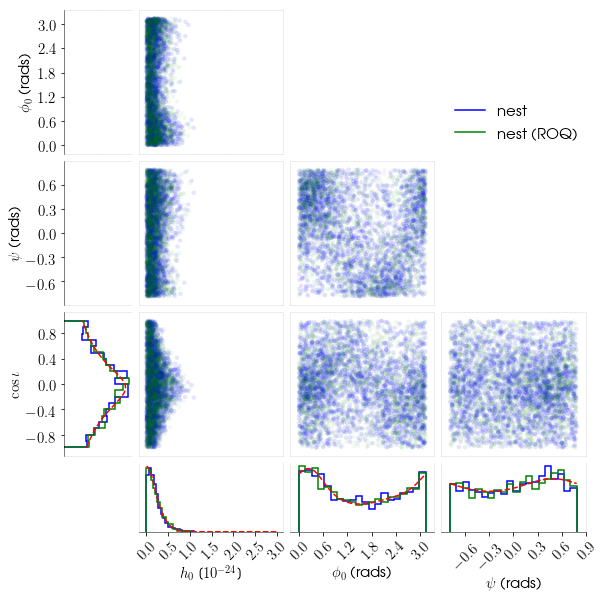

In [57]:
from scipy.stats import ks_2samp

# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
Ds = []
pvalues = []
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]
    postppenroq[:,i] = postroq[p].samples[:,0]
    D, pvalue = ks_2samp(postppen[:,i], postppenroq[:,i])
    Ds.append(D)
    pvalues.append(pvalue)

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5,
           'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0., np.pi), (-np.pi/4., np.pi/4.), (-1., 1.)]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, datatitle='nest')

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5}

# add the ROQ run
sc.add_data(postppenroq, hist_kwargs=histops, datatitle='nest (ROQ)')

# plot output from grid-based parameter estimation
ax = sc.get_axis(r'$h_0$')
ax.plot(h0pdf[:,0], h0pdf[:,1], 'r--')

ax = sc.get_axis(r'$\phi_0$ (rads)')
ax.plot(phipdf[:,0]/2., phipdf[:,1]*2., 'r--')

ax = sc.get_axis(r'$\psi$ (rads)')
ax.plot(psipdf[:,0], psipdf[:,1], 'r--')

ax = sc.get_axis(r'$\cos{\iota}$')
ax.plot(cipdf[:,1], cipdf[:,0], 'r--')

sc.show()

# compare 95% upper limits
h0ulgrid = np.interp(0.95, h0pdf[:,2], h0pdf[:,0])

print(r'h_0 95% UL (nest): {0:.2e}'.format(h0ul))
print(r'h_0 95% UL (nest ROQ): {0:.2e}'.format(h0ulroq))
print(r'h_0 95% UL (grid): {0:.2e}'.format(h0ulgrid))
print(r'Percentage difference: {0:.1f}%'.format(100.*np.abs(h0ul-h0ulgrid)/h0ul))

print(r'p-value that samples are from the same distribution: {}'.format(np.min(pvalues)))

## Simulated Gaussian noise - single harmonic

In the below test I will run `lalapps_pulsar_parameter_estimation_nested` on simulated Gaussian noise for two detectors (H1 and L1) for a signal emitting entirely at twice the rotation frequency of a given pulsar. The parameter estimation will be performed over the four signal parameters $C_{22}$, $\Phi_{22}$, $\psi$ and $\cos{\iota}$, where $C_{22}$ and $\Phi_{22}$ are related to the more standard $h_0$ and $\phi_0$ through the relationships in Appendix 3 of [Pitkin _et al_ (2015)](https://arxiv.org/abs/1508.00416). The test is performed on a number of instantiations of simulated noise, and the "averaged" results are also plotted.

In the case of a single harmonic at twice the rotation frequency being used, the function `pulsar_nest_to_posterior` automatically converts $C_{22}$ and $\Phi_{22}$ to $h_0$ and $\phi_0$.

In [28]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*2      # 2 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# run multiple times to see "average" results
Nruns = 25

posts = []
h0uls = []

for i in range(Nruns):
    # set the command line arguments
    runcmd = ' '.join([lppen,
                       '--fake-data', detectors,
                       '--fake-starts', '{},{}'.format(starttime, starttime),
                       '--fake-lengths', '{},{}'.format(duration, duration),
                       '--fake-dt', '{},{}'.format(dt, dt),
                       '--par-file', parfile,
                       '--prior-file', priorfile,
                       '--harmonics', '{}'.format(harmonics),
                       '--Nlive', '{}'.format(Nlive),
                       '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                       '--tolerance', '{}'.format(tolerance),
                       '--outfile', outfile])

    p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # nested samples need to be converted to posterior samples with lalapps_nest2pos
    outpost = 'post.hdf'
    runcmd = ' '.join([n2p, '-p', outpost, outfile])
    p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    post, evsig, evnoise = pulsar_nest_to_posterior(outpost);
    h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=0.95)
    
    posts.append(post)
    h0uls.append(h0ul)

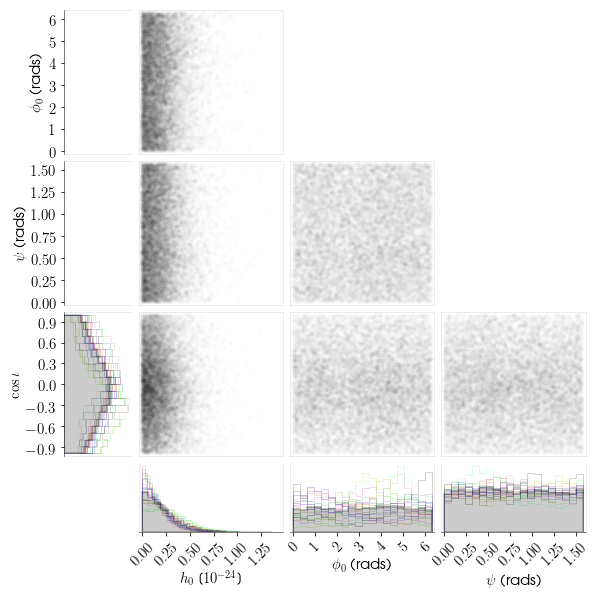

In [36]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA']

colors = [np.random.rand(3,) for i in range(Nruns)]

labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

postppens = {}
for p in params:
    postppens[p] = []

for k in range(Nruns):
    # lalapps_pulsar_parameter_estimation_nested posterior samples
    lp = len(posts[k]['h0'].samples)
    postppen = np.zeros((lp, len(params)))
    for i, p in enumerate(params):
        postppen[:,i] = posts[k][p].samples[:,0]
        postppens[p].append(posts[k][p].samples[np.random.choice(lp, size=500, replace=False),0])

    histops = {'histtype': 'step', 'color': colors[k], 'edgecolor': colors[k],
               'linewidth': 1.0, 'alpha': 0.2}

    # NOTE: phi0 here (when converted from PHI22) is the GW phase, not the pulsar rotational phase as above

    # add the standard run
    if k == 0:
        sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                          hist_kwargs=histops, showcontours=False,
                          showpoints=False)
    else:
        sc.add_data(postppen, hist_kwargs=histops, showpoints=False)

# show "average"
postppensarr = np.array([np.hstack(pp) for pp in [postppens[p] for p in params]]).T
histops = {'histtype': 'stepfilled', 'color': [(0.,0.,0.,0.2)], 'edgecolor': (0.,0.,0.,1.),
           'linewidth': 2.0}
sc.add_data(postppensarr, hist_kwargs=histops, showcontours=False, showpoints=True,
            scatter_kwargs={'alpha': 0.01}, limits=limits)

sc.show()

## Simulated Gaussian noise - two harmonics

In the below test I will run `lalapps_pulsar_parameter_estimation_nested` on simulated Gaussian noise for two detectors (H1 and L1) for a signal emitting at both once and twice the rotation frequency of a given pulsar. The parameter estimation will be performed over the six signal parameters $C_{22}$, $C_{21}$, $\Phi_{22}$, $\Phi_{21}$, $\psi$ and $\cos{\iota}$.

The test is performed on a number of realisations of simulated noise and an "average" is also shown.

In [37]:
%%capture

detectors = 'H1,L1'
harmonics = [1, 2]
starttime = 1164556817  # start of O2
duration = 86400*2      # 2 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
C21      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PHI21    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# run multiple times to see "average" results
Nruns = 100

posts = []

for i in range(Nruns):
    # set the command line arguments
    runcmd = ' '.join([lppen,
                       '--fake-data', detectors,
                       '--fake-starts', '{},{},{},{}'.format(starttime, starttime, starttime, starttime),
                       '--fake-lengths', '{},{},{},{}'.format(duration, duration, duration, duration),
                       '--fake-dt', '{},{},{},{}'.format(dt, dt, dt, dt),
                       '--par-file', parfile,
                       '--prior-file', priorfile,
                       '--harmonics', '{},{}'.format(harmonics[0], harmonics[1]),
                       '--Nlive', '{}'.format(Nlive),
                       '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                       '--tolerance', '{}'.format(tolerance),
                       '--outfile', outfile])

    p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # nested samples need to be converted to posterior samples with lalinference_nest2pos
    outpost = 'post.hdf'
    runcmd = ' '.join([n2p, '-p', outpost, outfile])
    p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

    posts.append(post)

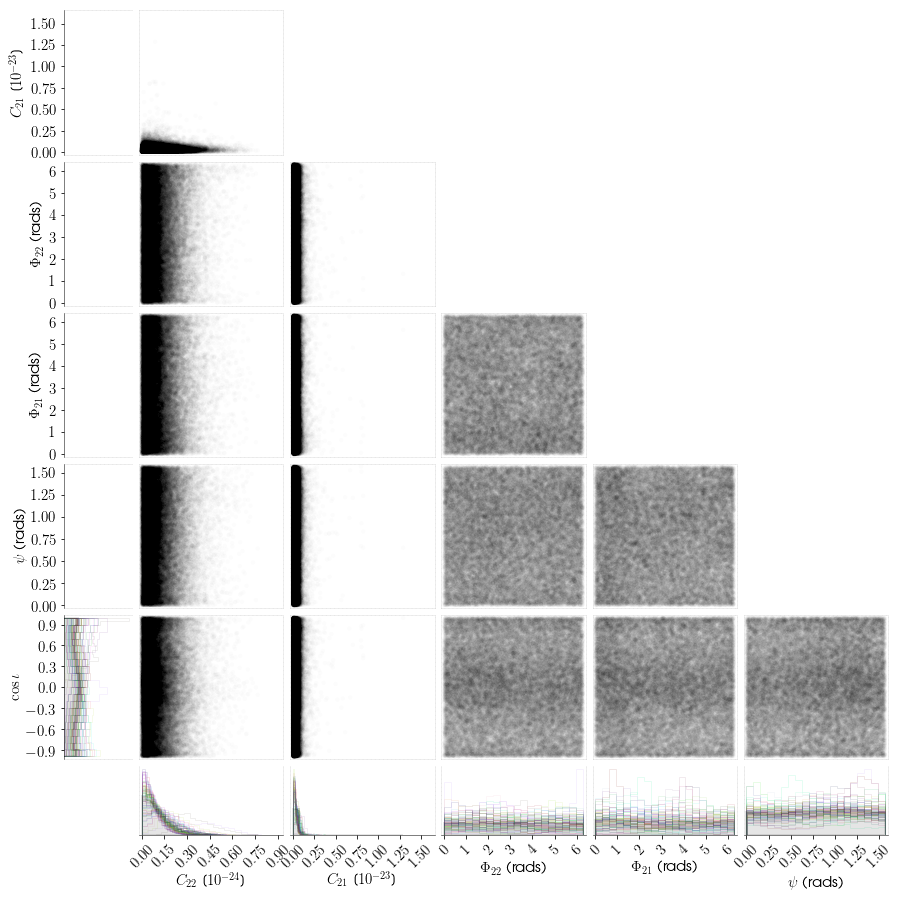

In [38]:
# get required parameter columns
params = ['C22', 'C21', 'PHI22', 'PHI21', 'PSI', 'COSIOTA']

colors = [np.random.rand(3,) for i in range(Nruns)]

labels = [u'$C_{22}$', u'$C_{21}$', u'$\Phi_{22}$ (rads)', u'$\Phi_{21}$ (rads)',
          u'$\psi$ (rads)', u'$\cos{\iota}$']
limits = [(0., None), (0, None), (0., 2.*np.pi), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

postppens = {}
for p in params:
    postppens[p] = []

for k in range(Nruns):
    # lalapps_pulsar_parameter_estimation_nested posterior samples
    lp = len(posts[k]['c22'].samples)
    postppen = np.zeros((lp, len(params)))
    for i, p in enumerate(params):
        postppen[:,i] = posts[k][p].samples[:,0]
        postppens[p].append(posts[k][p].samples[np.random.choice(lp, size=500, replace=False),0])

    histops = {'histtype': 'step', 'color': colors[k], 'edgecolor': colors[k],
               'linewidth': 1.0, 'alpha': 0.1}

    # add the standard run
    if k == 0:
        sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                          hist_kwargs=histops, showcontours=False, showpoints=False)
    else:
        sc.add_data(postppen, hist_kwargs=histops, showpoints=False)

# show "average"
postppensarr = np.array([np.hstack(pp) for pp in [postppens[p] for p in params]]).T
histops = {'histtype': 'stepfilled', 'color': [(0.,0.,0.,0.2)],
           'edgecolor': (0.,0.,0.,1.), 'linewidth': 2}
sc.add_data(postppensarr, hist_kwargs=histops, showcontours=False, showpoints=True,
            scatter_kwargs={'alpha': 0.01}, limits=limits)

sc.show()

## Simulated signal - single harmonic

In the below test I will run `lalapps_pulsar_parameter_estimation_nested` on data containing simulated Gaussian noise and a simulated pulsar signal. The data is generated for two detectors (H1 and L1) and for a signal emitting entirely at twice the rotation frequency of a given pulsar. The parameter estimation will be performed over the four signal parameters $C_{22}$, $\Phi_{22}$, $\psi$ and $\cos{\iota}$, where $C_{22}$ and $\Phi_{22}$ are related to the more standard $h_0$ and $\phi_0$ through the relationships in Appendix 3 of [Pitkin _et al_ (2015)](https://arxiv.org/abs/1508.00416).

In the case of a single harmonic at twice the rotation frequency being used, the function `pulsar_nest_to_posterior` automatically converts $C_{22}$ and $\Phi_{22}$ to $h_0$ and $\phi_0$.

I will run on two simulated signals. The first will have the same parameters as the hardware injection `PULSA00` and the second will have the same parameter except for `COSIOTA`, which will be set to zero to create a linearly polarised signal.

In [58]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*10     # 10 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

# run using ROQ
runcmd = ' '.join([lppen,
                   '--detectors', detectors,
                   '--input-files', '{},{}'.format('{}_{}_{}'.format(datafile, 'H1', '2.0'),
                                                   '{}_{}_{}'.format(datafile, 'L1', '2.0')),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--oldChunks',
                   '--roq',
                   '--ntraining', '{}'.format(2000),
                   '--roq-tolerance', '{}'.format(5e-12)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

postroq, evsigroq, evnoise = pulsar_nest_to_posterior(outpost);

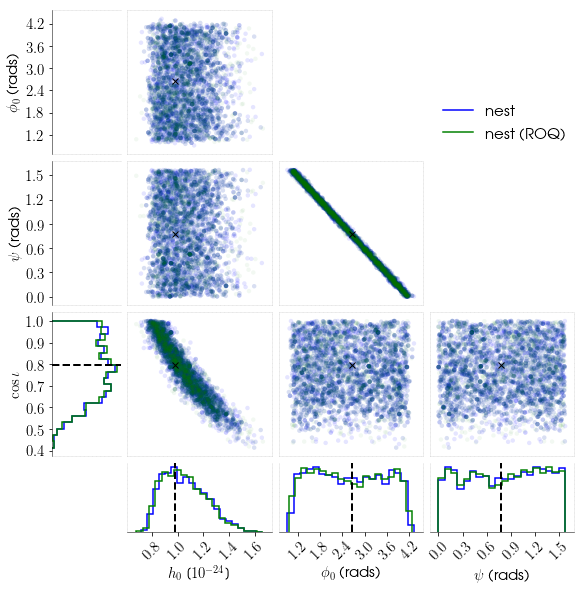

In [59]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]
    postppenroq[:,i] = postroq[p].samples[:,0]

pardata = psr_par('test.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [u'$h_0$', u'$\phi_0$ (rads)', u'$\psi$ (rads)', u'$\cos{\iota}$']
limits = [(0., None), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], 2.*pardata['PHI0'], pardata['PSI'], pardata['COSIOTA']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2}, datatitle='nest')

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5}

# add the ROQ run
sc.add_data(postppenroq, hist_kwargs=histops, datatitle='nest (ROQ)')

sc.show()

Ths run below sets the injected signal's `COSIOTA` value to zero to give a linearly polarised signal.

In [22]:
%%capture

# use the parameters of O2 hardware injection PULSAR0, but with COSIOTA of 0

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*10     # 10 days
dt = 60                 # 60 second sample interval

parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.0
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

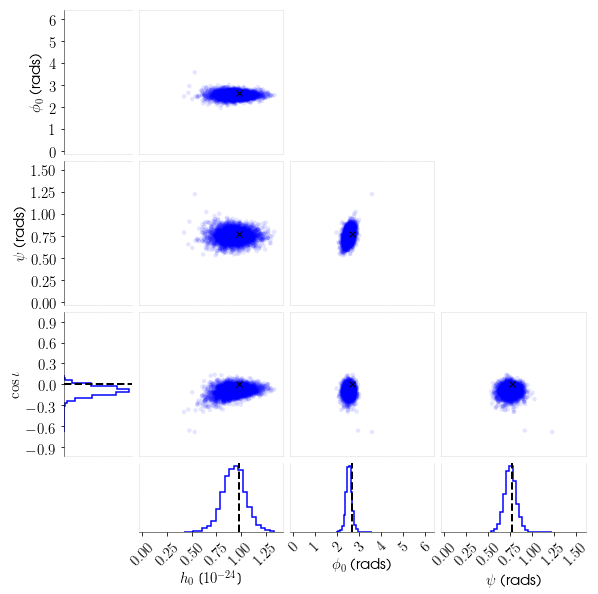

In [23]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('test.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], 2.*pardata['PHI0'], pardata['PSI'], pardata['COSIOTA']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

## Simulated signal - two harmonics

In the below test I will run `lalapps_pulsar_parameter_estimation_nested` on data containing simulated Gaussian noise and a signal for two detectors (H1 and L1). The signal will be emitting at both once and twice the rotation frequency of a given pulsar. The parameter estimation will be performed over the six signal parameters $C_{22}$, $C_{21}$, $\Phi_{22}$, $\Phi_{21}$, $\psi$ and $\cos{\iota}$.

I will again run on two signals. One will be close to linearly polarised and the other will be close to circularly polarised.

In [60]:
%%capture

detectors = 'H1,L1'
harmonics = [1, 2]
starttime = 1164556817  # start of O2
duration = 86400*10     # 10 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with COSIOTA close to 0 (linearly polarised)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
C22       8.8e-25
C21       6.3e-25
COSIOTA   0.1
PSI       0.2
PHI21     1.3
PHI22     4.5
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
C21      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PHI21    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{},{},{}'.format(starttime, starttime, starttime, starttime),
                   '--fake-lengths', '{},{},{},{}'.format(duration, duration, duration, duration),
                   '--fake-dt', '{},{},{},{}'.format(dt, dt, dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{},{}'.format(harmonics[0], harmonics[1]),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

# run using ROQ
runcmd = ' '.join([lppen,
                   '--detectors', detectors,
                   '--input-files', '{},{},{},{}'.format('{}_{}_{}'.format(datafile, 'H1', '1.0'),
                                                         '{}_{}_{}'.format(datafile, 'H1', '2.0'),
                                                         '{}_{}_{}'.format(datafile, 'L1', '1.0'),
                                                         '{}_{}_{}'.format(datafile, 'L1', '2.0')),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--oldChunks',
                   '--roq',
                   '--ntraining', '{}'.format(2000),
                   '--roq-tolerance', '{}'.format(5e-12)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

postroq, evsigroq, evnoise = pulsar_nest_to_posterior(outpost);

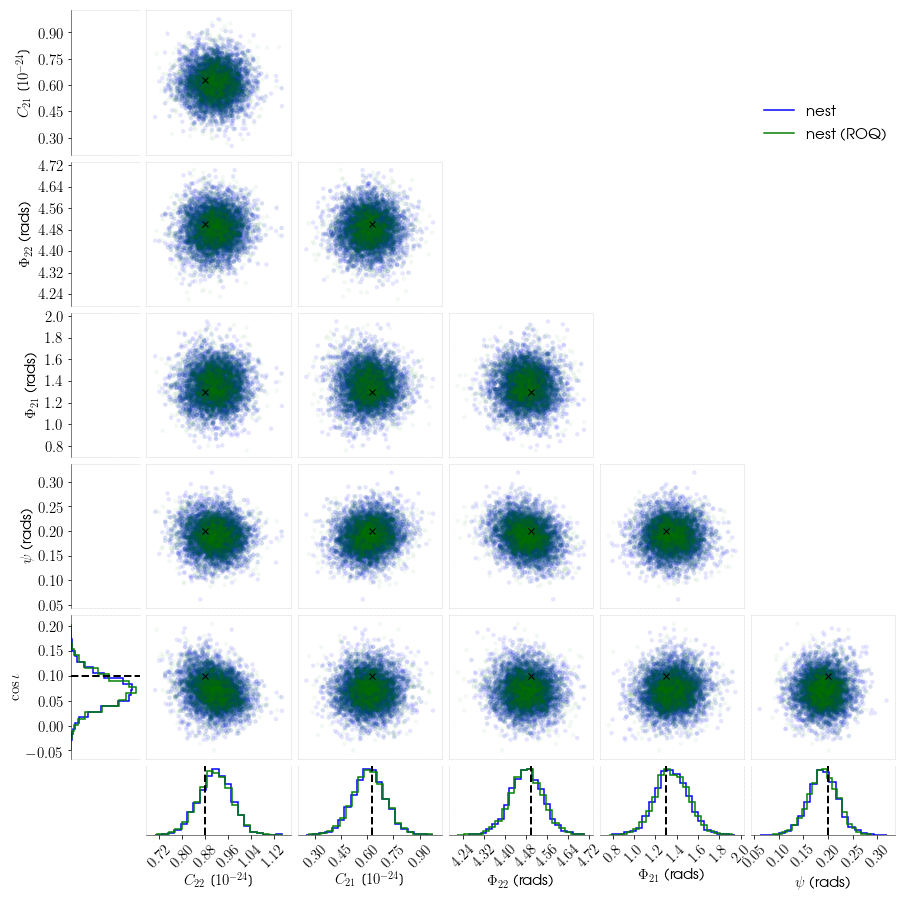

In [61]:
# get required parameter columns
params = ['C22', 'C21', 'PHI22', 'PHI21', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['c22'].samples), len(params)))
postppenroq = np.zeros((len(postroq['c22'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]
    postppenroq[:,i] = postroq[p].samples[:,0]

pardata = psr_par('test.par')
    
histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$C_{22}$', r'$C_{21}$', r'$\Phi_{22}$ (rads)', r'$\Phi_{21}$ (rads)',
          r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0, None), (0., 2.*np.pi), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

# injected parameter values
truths = [pardata['C22'], pardata['C21'], pardata['PHI22'], pardata['PHI21'],
          pardata['PSI'], pardata['COSIOTA']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2}, datatitle='nest')

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5}

# add the ROQ run
sc.add_data(postppenroq, hist_kwargs=histops, datatitle='nest (ROQ)')

sc.show()

Do the same as above, but with a close-to-circularly polarised signal.

In [26]:
%%capture

detectors = 'H1,L1'
harmonics = [1, 2]
starttime = 1164556817  # start of O2
duration = 86400*10     # 10 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with COSIOTA close to -1 (circularly polarised)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
C22       8.8e-25
C21       6.3e-25
COSIOTA   -0.85
PSI       1.1
PHI21     4.7
PHI22     1.5
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
C21      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PHI21    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{},{},{}'.format(starttime, starttime, starttime, starttime),
                   '--fake-lengths', '{},{},{},{}'.format(duration, duration, duration, duration),
                   '--fake-dt', '{},{},{},{}'.format(dt, dt, dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{},{}'.format(harmonics[0], harmonics[1]),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

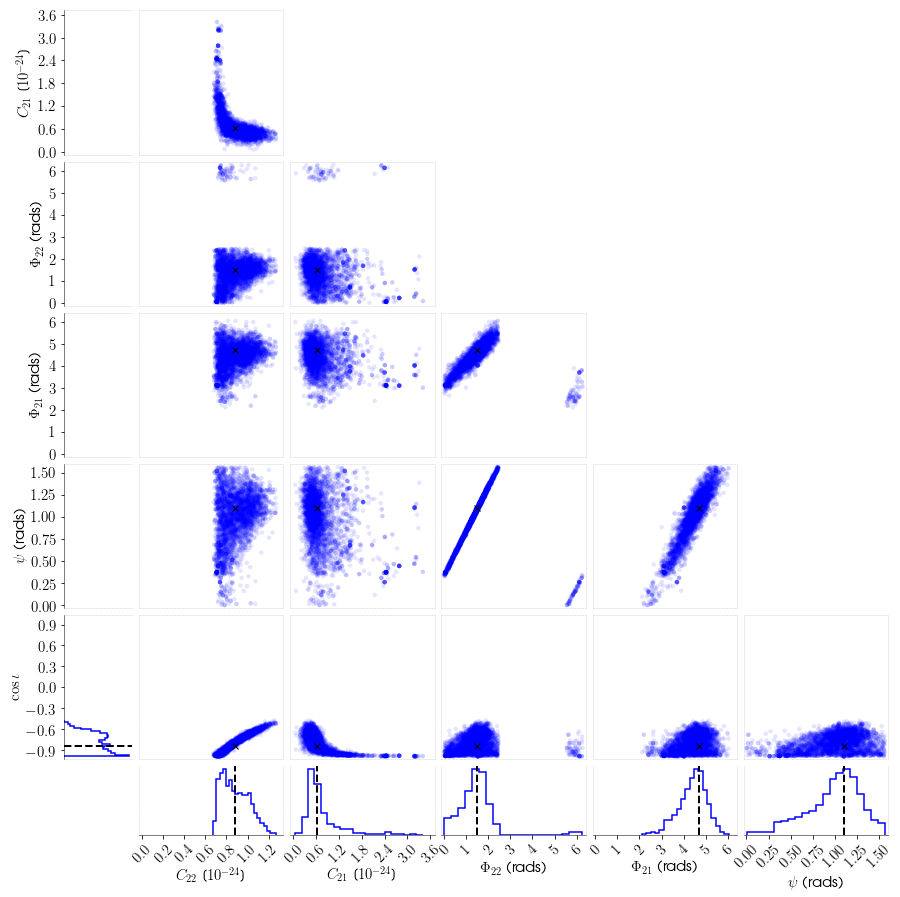

In [27]:
# get required parameter columns
params = ['C22', 'C21', 'PHI22', 'PHI21', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['c22'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('test.par')
    
histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$C_{22}$', r'$C_{21}$', r'$\Phi_{22}$ (rads)', r'$\Phi_{21}$ (rads)',
          r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0, None), (0., 2.*np.pi), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

# injected parameter values
truths = [pardata['C22'], pardata['C21'], pardata['PHI22'], pardata['PHI21'],
          pardata['PSI'], pardata['COSIOTA']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

## Hardware injection - single harmonic

In the below test I run the analysis for a hardware injection in O2 data (`PULSAR00`). The analysis searches over the four standard parameters using data from a single detector. It just uses ten days worth of data.

In [39]:
%%capture

# use the parameters of O2 hardware injection PULSAR0
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    52944.0007428703684126958
UNITS     TDB
H0        9.814765205714328e-25
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

datafile = 'fine-H1-1164556817-1187733618.txt.gz'
detectors = 'H1'
harmonics = 2

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--detectors', detectors,
                   '--input-files', datafile,
                   '--truncate-samples', '{}'.format(duration),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

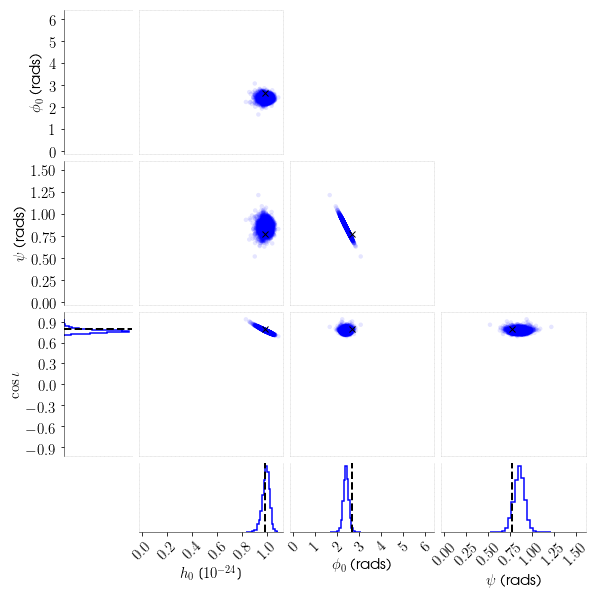

In [43]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('test.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$']
limits = [(0., None), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], 2.*pardata['PHI0'], pardata['PSI'], pardata['COSIOTA']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

# Simulated signal - single harmonic and ROQ

In the test below I will run the analysis for a simulated signal injected into Gaussian noise for two detectors. The signal will be for a single harmonic. Unlike the above similar test, here I will search over a small range of frequency and sky position parameters, using the ROQ to speed up the likelihood evaluation. The simulated signal will be injected at the centre of the search ranges.

The period epoch of the simulated signal is changed to be closer to the time of the data.

In [62]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*10     # 10 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with the signal amplitude increased
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    57722
UNITS     TDB
H0        1.814765205714328e-24
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior (including F0, F1, RAJ and DECJ)
priorcontent = """
C22      fermidirac 1e-23       9.1625
PHI22    uniform    0.0         6.2831853071795862
PSI      uniform    0.0         1.5707963267948966
COSIOTA  uniform    -1.0        1.0
F0       uniform    132.7885521 132.7885531
RA       uniform    1.248   1.249
DEC      uniform    -0.982 -0.981
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

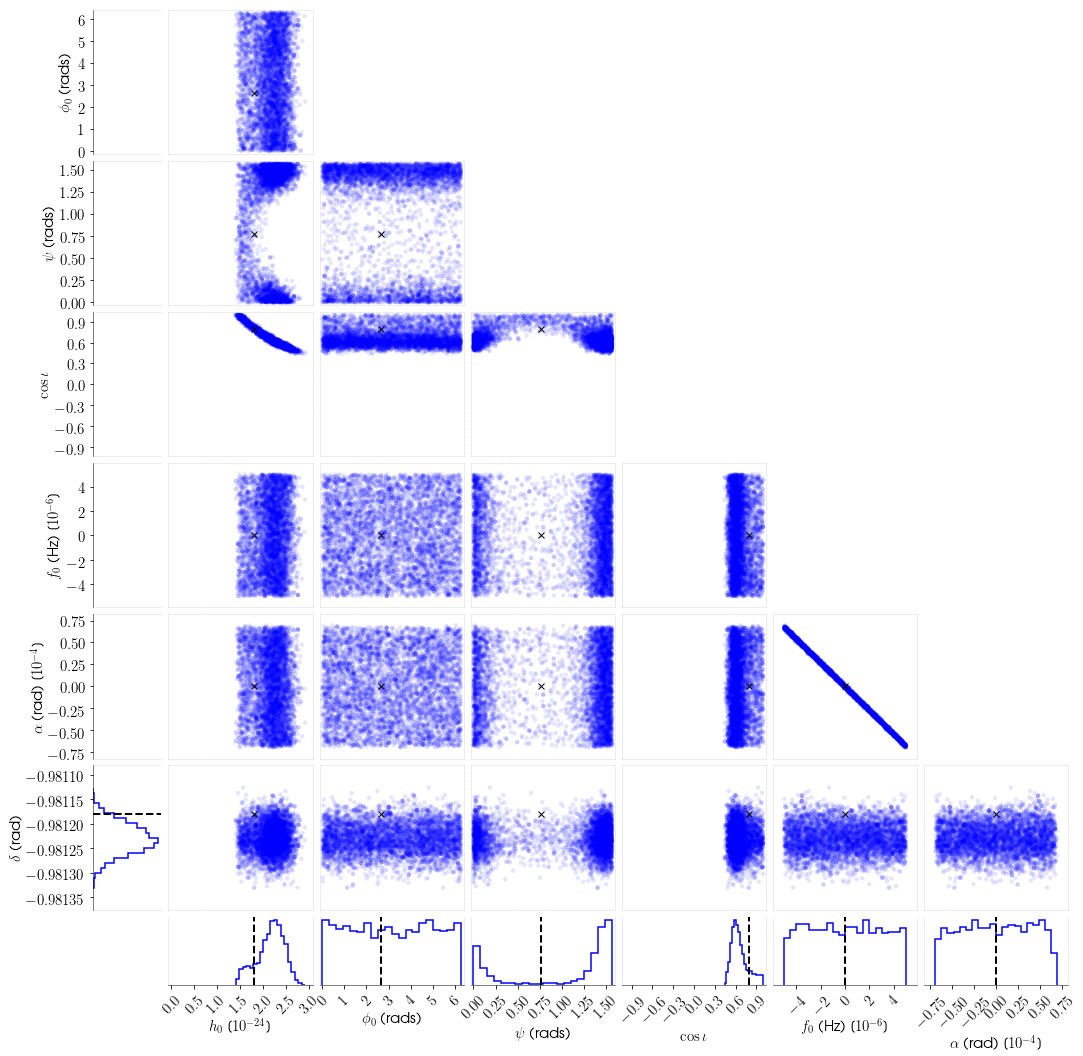

In [63]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA', 'F0', 'RA', 'DEC']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('test.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$',
          r'$f_0$ (Hz)', r'$\alpha$ (rad)', r'$\delta$ (rad)']
limits = [(0., None), (0., 2.*np.pi), (0., np.pi/2.), (-1., 1.),
          (None, None), (None, None), (None, None)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], 2.*pardata['PHI0'], pardata['PSI'], pardata['COSIOTA'],
          pardata['F0'], pardata['RA_RAD'], pardata['DEC_RAD']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2},
                  subtract_truths=[4, 5])

sc.show()

Analyse a similar signal, but this time searching over different parameters and using Gaussian priors.

In [66]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*2      # 2 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with the signal amplitude increased
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    57722
UNITS     TDB
H0        7.814765205714328e-24
COSIOTA   0.79490528185004428
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior (including F1 and RAJ)
priorcontent = """
C22      fermidirac 1e-23       9.1625
COSIOTA  uniform    -1.0        1.0
F1       gaussian   -2.075e-12  1e-14
RA       gaussian   1.248816734 5e-4
"""

duration = 2*1440  # reduce the duration to two days

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

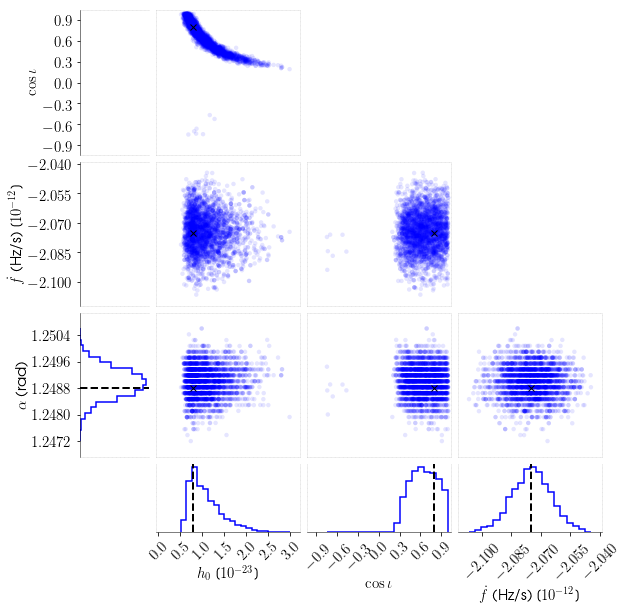

In [67]:
# get required parameter columns
params = ['H0', 'COSIOTA', 'F1', 'RA']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('test.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\cos{\iota}$',
          r'$\dot{f}$ (Hz/s)', r'$\alpha$ (rad)']
limits = [(0., None), (-1., 1.),
          (None, None), (None, None)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], pardata['COSIOTA'],
          pardata['F1'], pardata['RA_RAD']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2},
                  subtract_truths=[4, 5])

sc.show()

In the below analysis I will purposely offset the injected signal from the assumed values to check that they can still be correctly recovered. The signal will be offset in frequency by a few frequency bins, and offset in declination. In the plot of recovered posteriors below, the black dashed lines show the true signal parameters and the red lines (for frequency and declination) show the "expected" parameters (i.e., the values that the signal was heterodyned at).

In [90]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*5      # 5 days
dt = 60                 # 60 second sample interval

# the expected parameters of the signal
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    57722
UNITS     TDB
H0        9.914765205714328e-24
COSIOTA   0.1
PSI       0.770087086
PHI0      1.33
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# the "actual" parameters of the signal
parcontent = """
PSRJ      JPULSAR00
F0        132.7885581
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:15:47.94
PEPOCH    57722
UNITS     TDB
H0        7.914765205714328e-24
COSIOTA   0.1
PSI       0.770087086
PHI0      1.33
"""

injparfile = 'inj.par'
fp = open(injparfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior (including F0 and DECJ)
priorcontent = """
C22      fermidirac 1e-23       9.1625
PSI      uniform    0.0         1.5707963267948966
COSIOTA  uniform    -1.0        1.0
F0       uniform    132.78855   132.78856
DEC      uniform    -0.983      -0.980
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', injparfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

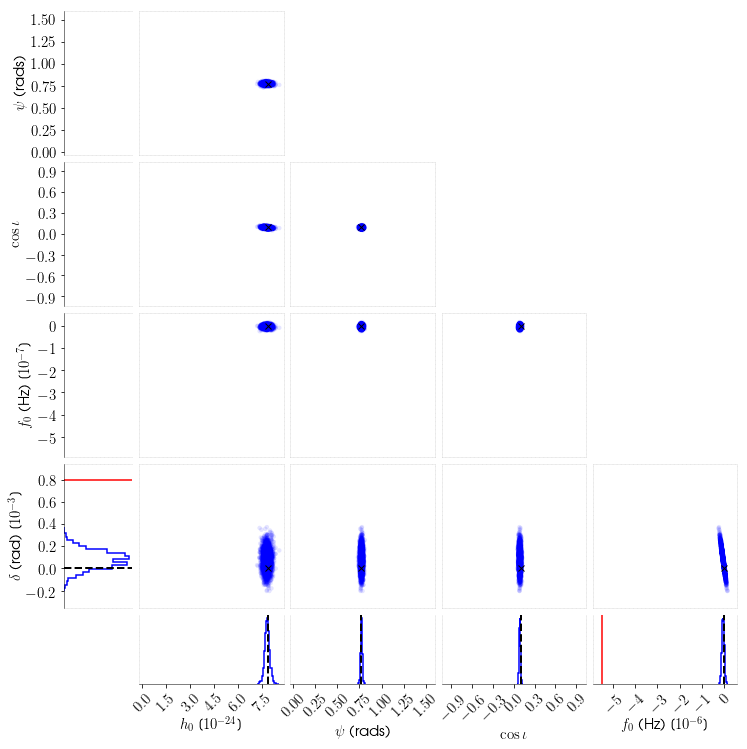

In [91]:
# get required parameter columns
params = ['H0', 'PSI', 'COSIOTA', 'F0', 'DEC']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

pardata = psr_par('inj.par')

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\psi$ (rads)', r'$\cos{\iota}$', r'$f_0$ (Hz)', r'$\delta$ (rad)']
limits = [(0., None), (0., np.pi/2.), (-1., 1.), (None, None), (None, None)]

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata['H0'], pardata['PSI'], pardata['COSIOTA'],
          pardata['F0'], pardata['DEC_RAD']]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2},
                  subtract_truths=[3, 4])

# add the "expected" positions (different than the true values)
pardata_e = psr_par('test.par')

df0 = pardata_e['F0'] - pardata['F0']
ddec = pardata_e['DEC_RAD'] - pardata['DEC_RAD']

ax = sc.get_axis(r'$f_0$ (Hz)')
ax.axvline(df0, color='r')

ax = sc.get_axis(r'$\delta$ (rad)')
ax.axhline(ddec, color='r')

sc.show()

## Simulated Gaussian noise - single harmonic and glitch

In the test below I will run the analysis for a simulated Gaussian noise for two detectors. Unlike the above similar test, here I will perform parameter estimation assuming a glitch in the pulsar signal halfway through the data. This adds an additional phase offset parameter at the time of the glitch.

In [18]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*4      # 4 days
dt = 60                 # 60 second sample interval

# the expected parameters of the signal
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    53400
UNITS     TDB
H0        9.914765205714328e-24
COSIOTA   0.1
PSI       0.770087086
PHI0      1.33
GLEP_1    57724.666666666
GLF0_1    0.0
GLPH_1    0.0
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
H0       fermidirac 1e-23       9.1625
PSI      uniform    0.0         1.5707963267948966
PHI0     uniform    0.0         3.141592653589793
COSIOTA  uniform    -1.0        1.0
GLPH_1   uniform    0.0         1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 2046
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

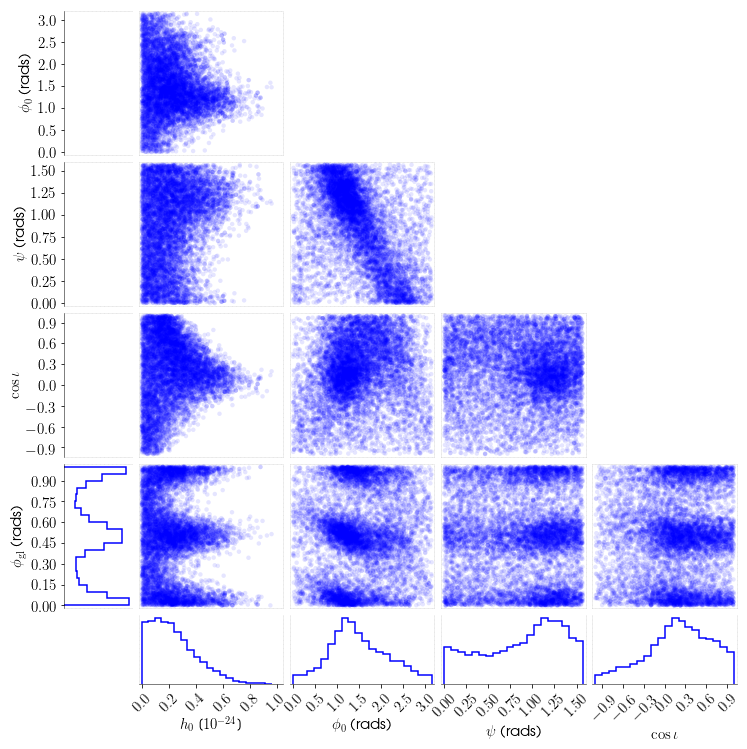

In [20]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA', 'GLPH_1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$',
          r'$\phi_{\rm{gl}}$ (rads)']
limits = [(0., None), (0., np.pi), (0., np.pi/2.), (-1., 1.), (0., 1.)]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1})

sc.show()

There a signs of correlations between the glitch phase $\phi_{\text{gl}}$ and the gravitational wave phase $\phi_0$. This would be expected as the part of the likelihood calculated using data before the glitch the phases will be uncorrelated as the glitch phase will be entirely unconstrained, whereas the likelihood from the data after the glitch the combination of the phases is unconstrained. In this search at purely twice the rotation frequency, having the glitch phase prior span from 0 to 1 cycles leaded to a duplication in the posterior.

Below, I'll add an injection with a glitch, for which the degeneracy should be broken.

In [24]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*4      # 4 days
dt = 60                 # 60 second sample interval

# the expected parameters of the signal (set the glitch epoch to just before the start of the data)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885581
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    57722.65
UNITS     TDB
H0        4.914765205714328e-24
COSIOTA   0.1
PSI       0.770087086
PHI0      1.33
GLEP_1    57724.666666666
GLF0_1    0.0
GLPH_1    0.25
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
H0       fermidirac 1e-23       9.1625
PSI      uniform    0.0         1.5707963267948966
PHI0     uniform    0.0         3.141592653589793
COSIOTA  uniform    -1.0        1.0
GLPH_1   uniform    0.0         1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()


# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

In [32]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA', 'GLPH_1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$',
          r'$\phi_{\rm{gl}}$ (rads)']
limits = [(0., None), (0., np.pi), (0., np.pi/2.), (-1., 1.), (0., 1.0)]

pardata = PulsarParametersPy(parfile)

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata.as_dict()['H0'], pardata.as_dict()['PHI0'], pardata['PSI'],
          pardata['COSIOTA'], pardata['GLPH'][0]]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

{'PSRJ': 'JPULSAR00', 'F': array([ 1.32788558e+02, -2.07500000e-12]), 'RAJ': 1.2488167340000016, 'DECJ': -0.981180225, 'PEPOCH': 1164555308.8160002, 'UNITS': 'TDB', 'H0': 4.914765205714328e-24, 'COSIOTA': 0.1, 'PSI': 0.770087086, 'PHI0': 1.33, 'GLEP': array([1.16472955e+09]), 'GLF0': array([0.]), 'GLPH': array([0.25])}
[4.914765205714328e-24, 1.33, 0.770087086, 0.1, 0.25]


However, if I set the glitch epoch to the start of the data the two phase parameters should be completely correlated.

In [36]:
%%capture

detectors = 'H1,L1'
harmonics = 2
starttime = 1164556817  # start of O2
duration = 86400*4      # 4 days
dt = 60                 # 60 second sample interval

# the expected parameters of the signal (set the glict epoch to just before the start of the data)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RAJ       04:46:12.4627784428
DECJ      -56:13:02.9490031074
PEPOCH    57722.65
UNITS     TDB
H0        4.914765205714328e-24
COSIOTA   0.1
PSI       0.770087086
PHI0      1.33
GLEP_1    57722.65
GLF0_1    0.0
GLPH_1    0.25
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior (including F0 and DECJ)
priorcontent = """
H0       fermidirac 1e-23       9.1625
PSI      uniform    0.0         1.5707963267948966
PHI0     uniform    0.0         3.141592653589793
COSIOTA  uniform    -1.0        1.0
GLPH_1   uniform    0.0         1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()


# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{}'.format(starttime, starttime),
                   '--fake-lengths', '{},{}'.format(duration, duration),
                   '--fake-dt', '{},{}'.format(dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{}'.format(harmonics),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

In [38]:
# get required parameter columns
params = ['H0', 'PHI0', 'PSI', 'COSIOTA', 'GLPH_1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$h_0$', r'$\phi_0$ (rads)', r'$\psi$ (rads)', r'$\cos{\iota}$',
          r'$\phi_{\rm{gl}}$ (rads)']
limits = [(0., None), (0., np.pi), (0., np.pi/2.), (-1., 1.), (0., 1.0)]

pardata = PulsarParametersPy(parfile)

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata.as_dict()['H0'], pardata.as_dict()['PHI0'], pardata['PSI'],
          pardata['COSIOTA'], pardata['GLPH'][0]]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

## Simulated signal - dual harmonic and glitch

In the test below I will run the analysis for a simulated Gaussian noise for two detectors. As in the previous test I will perform parameter estimation assuming a glitch in the pulsar signal halfway through the data, but this time for a dual harmonic signal.

In [41]:
%%capture

detectors = 'H1,L1'
harmonics = [1,2]
starttime = 1164556817  # start of O2
duration = 86400*4      # 4 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with COSIOTA close to 0 (linearly polarised)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    57722.65
UNITS     TDB
C22       8.8e-25
C21       7.3e-25
COSIOTA   0.1
PSI       0.2
PHI21     1.3
PHI22     4.5
GLEP_1    57724.666666666
GLF0_1    0.0
GLPH_1    0.3
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
C21      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PHI21    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
GLPH_1   uniform    0.0      1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{},{},{}'.format(starttime, starttime, starttime, starttime),
                   '--fake-lengths', '{},{},{},{}'.format(duration, duration, duration, duration),
                   '--fake-dt', '{},{},{},{}'.format(dt, dt, dt, dt),
                   '--par-file', parfile,
                   '--inject-file', parfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{},{}'.format(harmonics[0], harmonics[1]),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

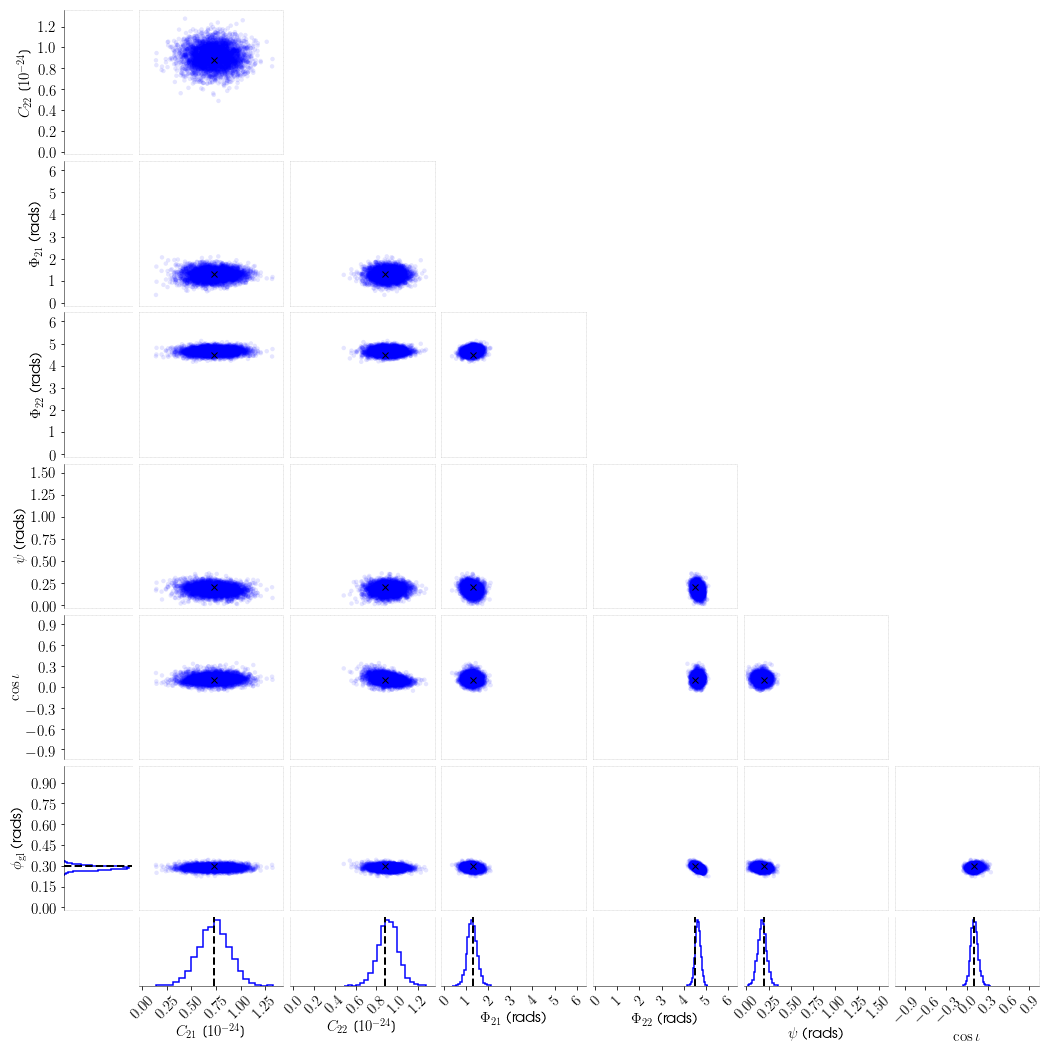

In [42]:
# get required parameter columns
params = ['C21', 'C22', 'PHI21', 'PHI22', 'PSI', 'COSIOTA', 'GLPH_1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['C21'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$C_{21}$', r'$C_{22}$', r'$\Phi_{21}$ (rads)', r'$\Phi_{22}$ (rads)',
          r'$\psi$ (rads)', r'$\cos{\iota}$', r'$\phi_{\rm{gl}}$ (rads)']
limits = [(0., None), (0., None), (0., 2.*np.pi), (0., 2.*np.pi),
          (0., np.pi/2.), (-1., 1.), (0., 1.0)]

pardata = PulsarParametersPy(parfile)

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata.as_dict()['C21'], pardata.as_dict()['C22'],
          pardata.as_dict()['PHI21'],  pardata.as_dict()['PHI22'], pardata['PSI'],
          pardata['COSIOTA'], pardata['GLPH'][0]]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()

Below, I will reproduce the above analysis, but in this case with the "EM" glitch phase and injection glitch phase being different.

In [43]:
%%capture

detectors = 'H1,L1'
harmonics = [1,2]
starttime = 1164556817  # start of O2
duration = 86400*4      # 4 days
dt = 60                 # 60 second sample interval

# use the parameters of O2 hardware injection PULSAR0, but with COSIOTA close to 0 (linearly polarised)
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    57722.65
UNITS     TDB
C22       8.8e-25
C21       7.3e-25
COSIOTA   0.1
PSI       0.2
PHI21     1.3
PHI22     4.5
GLEP_1    57724.666666666
GLF0_1    0.0
GLPH_1    0.3
"""

parfile = 'test.par'
fp = open(parfile, 'w')
fp.write(parcontent)
fp.close()

# set the prior
priorcontent = """
C22      fermidirac 1e-23    9.1625
C21      fermidirac 1e-23    9.1625
PHI22    uniform    0.0      6.2831853071795862
PHI21    uniform    0.0      6.2831853071795862
PSI      uniform    0.0      1.5707963267948966
COSIOTA  uniform    -1.0     1.0
GLPH_1   uniform    0.0      1.0
"""

priorfile = 'prior.txt'
fp = open(priorfile, 'w')
fp.write(priorcontent)
fp.close()

# injection file with a different glitch phase
parcontent = """
PSRJ      JPULSAR00
F0        132.7885526
F1        -2.075e-12
RA        04:46:12.4627784428
DEC       -56:13:02.9490031074
PEPOCH    57722.65
UNITS     TDB
C22       8.8e-25
C21       7.3e-25
COSIOTA   0.1
PSI       0.2
PHI21     1.3
PHI22     4.5
GLEP_1    57724.666666666
GLF0_1    0.0
GLPH_1    0.75
"""

injfile = 'inj.par'
fp = open(injfile, 'w')
fp.write(parcontent)
fp.close()

# nested sampling arguments
Nlive = 1024
Nmcmcinitial = 0  # set to 0 so that prior samples are not resampled
tolerance = 0.1   # nested sampling stopping criterion (0.1 is default value)

outfile = 'nest.hdf'

# ROQ parameters
ntraining = 4096
roqtol = 5e-12

# set the command line arguments
runcmd = ' '.join([lppen,
                   '--fake-data', detectors,
                   '--fake-starts', '{},{},{},{}'.format(starttime, starttime, starttime, starttime),
                   '--fake-lengths', '{},{},{},{}'.format(duration, duration, duration, duration),
                   '--fake-dt', '{},{},{},{}'.format(dt, dt, dt, dt),
                   '--par-file', parfile,
                   '--inject-file', injfile,
                   '--prior-file', priorfile,
                   '--harmonics', '{},{}'.format(harmonics[0], harmonics[1]),
                   '--Nlive', '{}'.format(Nlive),
                   '--Nmcmcinitial', '{}'.format(Nmcmcinitial),
                   '--tolerance', '{}'.format(tolerance),
                   '--outfile', outfile,
                   '--roq',
                   '--ntraining', '{}'.format(ntraining),
                   '--roq-tolerance', '{}'.format(roqtol)])

p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
outpost = 'post.hdf'
runcmd = ' '.join([n2p, '-p', outpost, outfile])
p = sp.Popen(runcmd, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

post, evsig, evnoise = pulsar_nest_to_posterior(outpost);

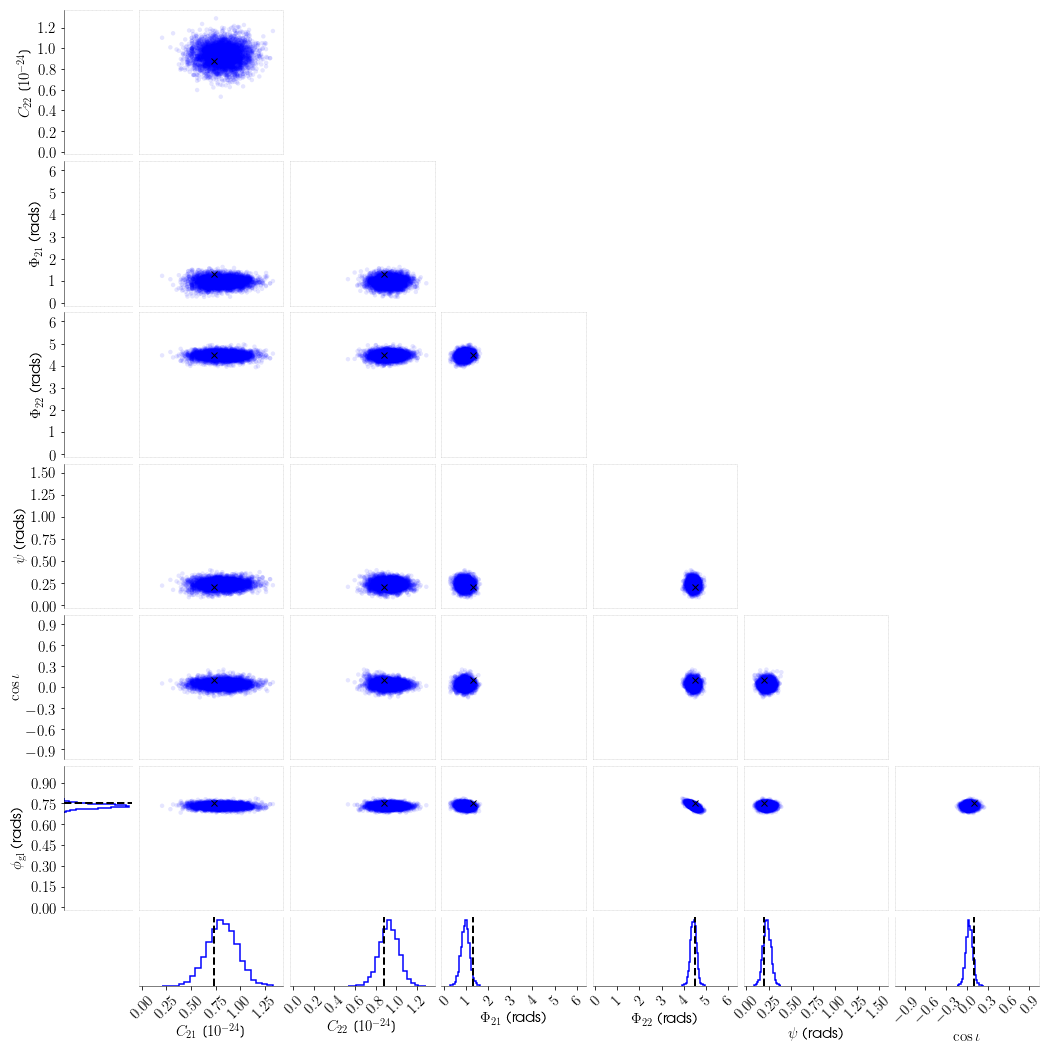

In [46]:
# get required parameter columns
params = ['C21', 'C22', 'PHI21', 'PHI22', 'PSI', 'COSIOTA', 'GLPH_1']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen = np.zeros((len(post['C21'].samples), len(params)))
for i, p in enumerate(params):
    postppen[:,i] = post[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = [r'$C_{21}$', r'$C_{22}$', r'$\Phi_{21}$ (rads)', r'$\Phi_{22}$ (rads)',
          r'$\psi$ (rads)', r'$\cos{\iota}$', r'$\phi_{\rm{gl}}$ (rads)']
limits = [(0., None), (0., None), (0., 2.*np.pi), (0., 2.*np.pi),
          (0., np.pi/2.), (-1., 1.), (0., 1.0)]

pardata = PulsarParametersPy(injfile)

# 'PHI0' in par file is rotational phase, so multiply by two for GW phase
truths = [pardata.as_dict()['C21'], pardata.as_dict()['C22'],
          pardata.as_dict()['PHI21'],  pardata.as_dict()['PHI22'], pardata['PSI'],
          pardata['COSIOTA'], pardata['GLPH'][0]]

# add the standard run
sc = scotchcorner(postppen, bins=20, ratio=2, labels=labels, showlims='both',
                  hist_kwargs=histops, showcontours=False, limits=limits,
                  showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'linewidth': 2})

sc.show()